# Particle simulation vs Langevin model

In [5]:
using ProgressMeter
using Revise

In [6]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist
using DifferentialEquations, Distributions

## Growing population

### Parameters

In [7]:
using Plots
# plotly()
gr()
# plotlyjs()
# pyplot()

Plots.GRBackend()

In [1]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
end

extendParams! (generic function with 1 method)

In [2]:
arenaParams = 
    Dict(
        "n0"=>100,
        "evolveTime"=>2000,
        "bounds"=>((0.,20.),(0.,20.)), 
        "radius"=>0.08, 
        "speed"=>0.02,
    )

growthParams =
    Dict(
        "ρ"=> 0.01,
        "k"=> 2000,
        "randGrowth"=> false,
        "waitTime"=> 200
    )

extendParams!(arenaParams)

display(arenaParams)
display(growthParams)

Dict{String,Any} with 7 entries:
  "volume"     => 400.0
  "evolveTime" => 2000
  "speed"      => 0.02
  "radius"     => 0.08
  "bounds"     => ((0.0, 20.0), (0.0, 20.0))
  "bperiod"    => [20.0, 20.0]
  "n0"         => 100

Dict{String,Real} with 4 entries:
  "waitTime"   => 200
  "k"          => 2000
  "ρ"          => 0.01
  "randGrowth" => false

### Logistic Growth

The number of cells in the system increases according to the logistic growth function:
\begin{equation}
n(t) = \frac{k}{ 1 + \frac{k-n_0}{n_0}e^{-\rho t}}
\end{equation}


Run Langevin simulations:

In [8]:
langevinEnsemble = Theorist.runLangevinSims(5000, arenaParams, growthParams);

Energy: 0.0002


Run a particle simulation:

In [9]:
arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID = BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams, growthParams);

Progress:  44%|██████████████████                       |  ETA: 0:00:16

anomalous collision time 1.214832296049921 found in time step
anomalous collision time 2.2172355247849618 found in time step
anomalous collision time 16.752593977195446 found in time step
anomalous collision time 6.837747170327069 found in time step
anomalous collision time 1.0300028616876382 found in time step
anomalous collision time 26.23872843937788 found in time step
anomalous collision time 10.29539975102963 found in time step
anomalous collision time 26.238728439377848 found in time step
anomalous collision time 2.216898543354109 found in time step
anomalous collision time 2.4136599512631762 found in time step
anomalous collision time 26.23872843937783 found in time step


Progress:  45%|██████████████████▌                      |  ETA: 0:00:17

anomalous collision time 26.325979426578215 found in time step


Progress:  55%|██████████████████████▋                  |  ETA: 0:00:17

anomalous collision time 5.02318603852838 found in time step


Progress:  58%|███████████████████████▉                 |  ETA: 0:00:17

anomalous collision time 1.0023109493590396 found in time step


Progress:  61%|█████████████████████████▏               |  ETA: 0:00:16

anomalous collision time 7.8042533911680225 found in time step


Progress:  63%|█████████████████████████▊               |  ETA: 0:00:15

anomalous collision time 1.0855809924960402 found in time step
anomalous collision time 2.3499570588246432 found in time step
anomalous collision time 13.382000496006533 found in time step
anomalous collision time 7.081848268366879 found in time step
anomalous collision time 13.705082482457994 found in time step
anomalous collision time 3.038224257220504 found in time step
anomalous collision time 13.465218692733862 found in time step
anomalous collision time 4.505234520757912 found in time step
anomalous collision time 12.397098896858529 found in time step
anomalous collision time 9.430053414731567 found in time step


Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:09

anomalous collision time 1.1525912019192348 found in time step


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


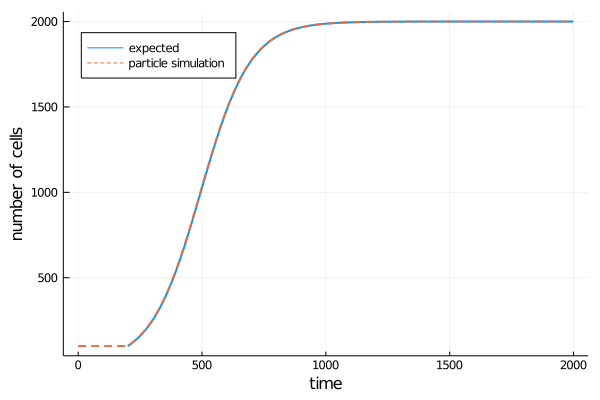

In [10]:
f1 = plot(growthParams["waitTime"]:(arenaParams["evolveTime"]-1), 
        Theorist.logisticGrowth.(0:(arenaParams["evolveTime"]-growthParams["waitTime"]-1), 
            growthParams["ρ"], growthParams["k"], arenaParams["n0"]), 
        label="expected", linewidth=2, legend=:topleft)
plot!(0:(arenaParams["evolveTime"]-1), BParts.nCellsTime(cells_T_ID)[1:end], linestyle=:dash, 
    label="particle simulation", linewidth=2)
xlabel!("time")
ylabel!("number of cells")
display(f1)

Ensemble of particle simulations:

In [ ]:
nSims = 100

pos_Sim = Array{Array{Union{Float64, Missing},3}}(undef, nSims)
@showprogress for i in 1:nSims
    succes = false
    while !succes 
        # try/catch construction in case boundserror occurs
        try
            _, posSim_t_dim_id, __, ___ = 
                BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams, growthParams; 
                    progress=false, verbose=false);
            pos_Sim[i] = posSim_t_dim_id
#             println("sim: ", i)
        catch e
           continue 
        end
        succes = true
    end
end

Progress:   3%|█▎                                       |  ETA: 2:30:01

### Mean squared displacement

In [9]:
msdTimes = (growthParams["waitTime"]+1, arenaParams["evolveTime"])

(201, 500)

In [10]:
msd_Sim = (p_t_dim_id -> BParts.meanSquaredDisplacement(p_t_dim_id, msdTimes)).(pos_Sim);
msdAv_t = Array{Float64, 1}(undef, msdTimes[2]-msdTimes[1]+1)
for i in 1:(msdTimes[2]-msdTimes[1]+1)
    msdAv_t[i] = mean([ msd_tt[i] for msd_tt in msd_Sim ])
end

In [11]:
timesMSD_t, msdLan_t = 
    Theorist.msd(
        langevinEnsemble, 
        arenaParams,
        (growthParams["waitTime"]+1, arenaParams["evolveTime"])
    )
# msdPar_t = BParts.meanSquaredDisplacement(pos_t_dim_id[1:msdTime,:,:], arenaParams["bperiod"]);

In [ ]:
p2 = plot(timesMSD_t, msdAv_t, label="particle simulation", legend=:bottomright, size=(400,300),dpi=140)
plot!(timesMSD_t, msdLan_t, label="Langevin simulation", linestyle=:dash)
display(p2)

# savefig(p2, "../Figures/growingPop_msd.png")